In [36]:
print("Bismillah Hirrahamaa Nirraheem")

Bismillah Hirrahamaa Nirraheem


In [37]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates['mod'] = go.layout.Template(layout=dict(font=dict(family="Fira Code",size=20)))
pio.templates.default = "plotly_dark+mod"
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from miceforest import ImputationKernel
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from missingno import matrix
from zipfile import ZipFile
from IPython.display import clear_output

In [38]:
!kaggle competitions download -c spaceship-titanic
!mv spaceship-titanic.zip /home/sohail/Downloads/
clear_output()

In [39]:
with ZipFile(file='/home/sohail/Downloads/spaceship-titanic.zip',mode="r") as file:
    file.extractall('/home/sohail/Downloads/spaceship-titanic-folder')

In [40]:
train = pd.read_csv('/home/sohail/Downloads/spaceship-titanic/train.csv')
test = pd.read_csv('/home/sohail/Downloads/spaceship-titanic/test.csv')
sample = pd.read_csv('/home/sohail/Downloads/spaceship-titanic/sample_submission.csv')

In [41]:
total = train.copy()

# Table
<font size=4>

|SI.No|Name of Column|Description|
|-----|--------------|-----------|
|1|PassengerId|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.|
|2|HomePlanet|The planet the passenger departed from, typically their planet of permanent residence|
|3|CryoSleep|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins|
|4|Cabin|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.|
|5|Destination|The planet the passenger will be debarking to|
|6|Age|The age of the passenger|
|7|VIP|Whether the passenger has paid for special VIP service during the voyage|
|8|RoomService, FoodCourt, ShoppingMall, Spa, VRDeck|Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities|
|9|Name|The first and last names of the passenger|
|10|Transported| Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict|

</font>

# Preprocessing

## Filling Nan's

In [42]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [43]:
total.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

as you can see there are quite a bit of Null values which need to be filled, we can apply some stratergies as we will see below

In [44]:
def preprocess_1(data:pd.DataFrame):
    df = data.copy()
    df[['CryoSleep','VIP']] = df[['CryoSleep','VIP']].astype(np.float32)
    df[['Group','Within']] = df.PassengerId.str.split('_',expand=True).astype(np.float32)
    df = df[df.columns[-2:].to_list()+df.columns[1:-2].to_list()]
    df[['deck','num','side']] = df.Cabin.str.split('/',expand=True)
    df = df[df.columns[:4].to_list() + df.columns[-3:].to_list() + df.columns[5:-3].to_list()]
    df['num'] = df['num'].astype(np.float32)
    df[['First','Last']] = df.Name.str.split(' ',expand=True)
    df = df[df.columns[:2].to_list() + df.columns[-2:].to_list() + df.columns[2:-2].to_list()]
    df.drop('Name',axis=1,inplace=True)
    return df.infer_objects()

In [45]:
total_train = preprocess_1(train)
total_test = preprocess_1(test)

In [46]:
total_df = pd.concat([total_train,total_test])
y_total = total_df[['Transported']]
total_df.drop('Transported',axis=1,inplace=True)
total_df.reset_index(inplace=True,drop=True)

In [47]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Group         12970 non-null  float32
 1   Within        12970 non-null  float32
 2   First         12676 non-null  object 
 3   Last          12676 non-null  object 
 4   HomePlanet    12682 non-null  object 
 5   CryoSleep     12660 non-null  float32
 6   deck          12671 non-null  object 
 7   num           12671 non-null  float32
 8   side          12671 non-null  object 
 9   Destination   12696 non-null  object 
 10  Age           12700 non-null  float64
 11  VIP           12674 non-null  float32
 12  RoomService   12707 non-null  float64
 13  FoodCourt     12681 non-null  float64
 14  ShoppingMall  12664 non-null  float64
 15  Spa           12686 non-null  float64
 16  VRDeck        12702 non-null  float64
dtypes: float32(5), float64(6), object(6)
memory usage: 1.4+ MB


In [48]:
total_df.isna().sum()

Group             0
Within            0
First           294
Last            294
HomePlanet      288
CryoSleep       310
deck            299
num             299
side            299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
dtype: int64

In [49]:
num_cols = ['Group','Within','num','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cat_cols = ['HomePlanet','CryoSleep','deck','side','Destination','VIP']
last_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
all_cats = []
for col in cat_cols:
    all_cats += total_df[col].dropna().unique().tolist()
all_cats

['Europa',
 'Earth',
 'Mars',
 0.0,
 1.0,
 'B',
 'F',
 'A',
 'G',
 'E',
 'D',
 'C',
 'T',
 'P',
 'S',
 'TRAPPIST-1e',
 'PSO J318.5-22',
 '55 Cancri e',
 0.0,
 1.0]

- Group, Within don't have any null values as they are from PassengerId column<br>
<br>
<font size=8>
Strategy :
</font>

- The strategy is to first fill null values according to the first and last names of the passengers as they are the closest relations for null values
- The First,Last columns also have null values so for the columns with null we will impute the most recurrent in terms of categorical column
- Then Look for the best predictors for single na values and impute those
- The impute the doubly filled columns with clustering/normal imputation


Missing Values

<Axes: >

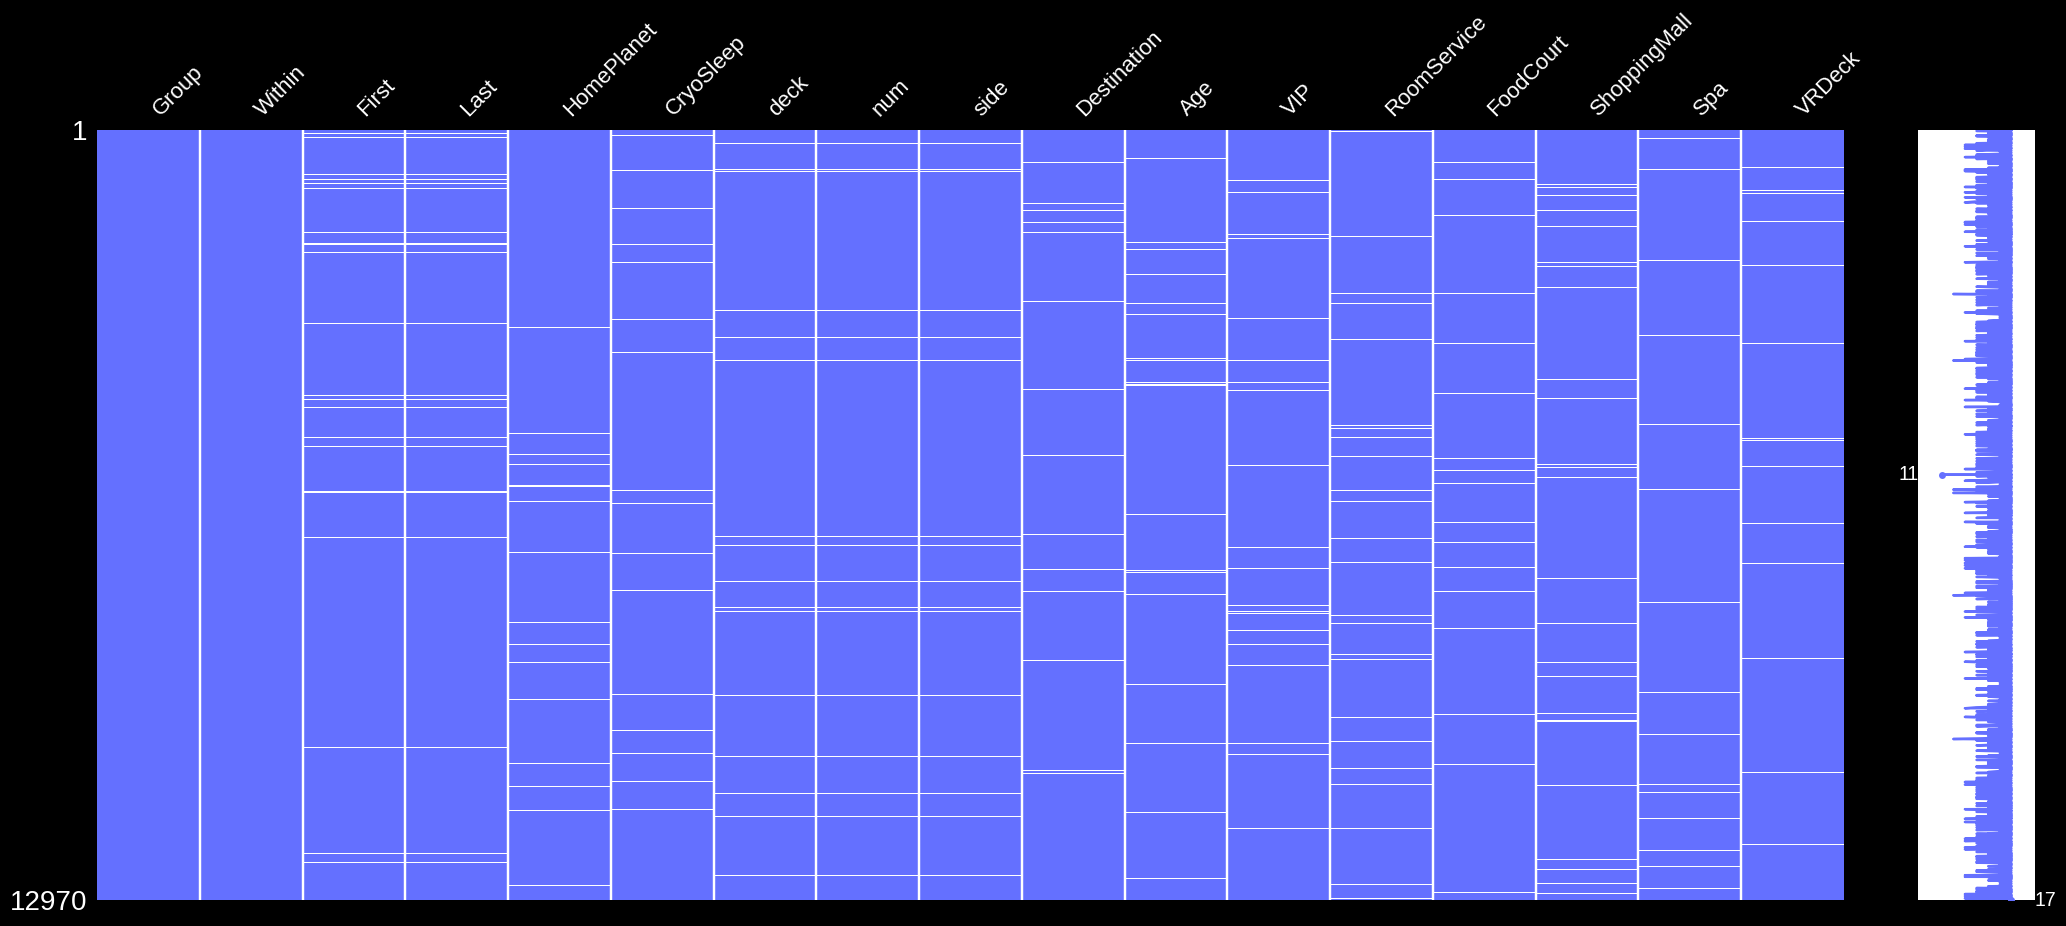

In [50]:
plt.style.use('dark_background')
matrix(total_df,color=(99/250,110/250,1))

In [51]:
total_no_na = total_df.dropna()
total_na = total_df[total_df.isna().any(axis=1)]
print("No NaN shape",total_no_na.shape)
print("any NaN shape",total_na.shape)

No NaN shape (9887, 17)
any NaN shape (3083, 17)


In [52]:
temp_df = pd.get_dummies(total_no_na,columns=['HomePlanet','deck','side','Destination'],prefix="",prefix_sep="",dtype=np.float32)
temp_df = temp_df.loc[:,temp_df.columns.difference(['First','Last'])].corr(method='spearman')
np.fill_diagonal(temp_df.to_numpy(),0)
px.imshow(temp_df,height=1000,width=1800).update_xaxes(tickangle=30)

filling the values with same First Name

before filling 

In [53]:
print("before filling :")
print("no of single vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 1)].shape[0])
print("no of double vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 2)].shape[0])
print("no of triple vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 3)].shape[0])

before filling :
no of single vacant rows : 2274
no of double vacant rows : 441
no of triple vacant rows : 303


In [54]:
for ind in total_na.index:
    col = total_na.columns[total_na.loc[ind].isna()]
    temp_df = total_no_na.query(f"Group == {total_na.loc[ind,'Group']} and Last == '{total_na.loc[ind,'Last']}'")
    if temp_df.shape[0] != 0:
        total_df.loc[ind,col] = temp_df.loc[temp_df.index[0],col]

In [55]:
print("after filling :")
print("no of single vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 1)].shape[0])
print("no of double vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 2)].shape[0])
print("no of triple vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 3)].shape[0])

after filling :
no of single vacant rows : 1466
no of double vacant rows : 364
no of triple vacant rows : 214


In [56]:
total_no_na = total_df.dropna()
total_na = total_df[total_df.isna().any(axis=1)]
print("No NaN shape",total_no_na.shape)
print("any NaN shape",total_na.shape)

No NaN shape (10880, 17)
any NaN shape (2090, 17)


In [57]:
total_na.head()

,Group,Within,First,Last,HomePlanet,CryoSleep,deck,num,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
15,12.0,1.0,Justie,Pooles,Earth,0.0,NaN,NaN,NaN,TRAPPIST-1e,31.0,0.0,32.0,0.0,876.0,0.0,0.0
16,14.0,1.0,Flats,Eccle,Mars,0.0,F,3.0,P,55 Cancri e,27.0,0.0,1286.0,122.0,NaN,0.0,0.0
27,22.0,1.0,NaN,NaN,Mars,0.0,D,0.0,P,TRAPPIST-1e,21.0,0.0,980.0,2.0,69.0,0.0,0.0
28,24.0,1.0,Penton,Fullided,Europa,1.0,C,2.0,S,TRAPPIST-1e,62.0,0.0,0.0,0.0,NaN,0.0,0.0
38,36.0,1.0,Marina,Leodger,Earth,0.0,F,8.0,S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,20.0,401.0


In [58]:
temp_df = pd.get_dummies(total_no_na,columns=['HomePlanet','deck','side','Destination'],prefix="",prefix_sep="",dtype=np.float32)
temp_df = temp_df.drop(['First','Last'],axis=1).corr(method='spearman')
np.fill_diagonal(temp_df.to_numpy(),0)
px.imshow(temp_df,height=1000,width=1800).update_xaxes(tickangle=30)

In [68]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [59]:
temp_df = total_df.drop(['First','Last'],axis=1)
temp_df = pd.get_dummies(temp_df,columns=['HomePlanet','side','deck','Destination'],prefix_sep="",prefix="",dtype=np.float32)
kds = ImputationKernel(temp_df,random_state=55,save_all_iterations=True,datasets=4)
kds.mice(10,n_estimators=100,max_depth=16,device="gpu")
new_data = kds.complete_data()

In [60]:
train_set = new_data.loc[:8692].copy()
test_set = new_data.loc[8693:].copy()

In [61]:
train_set.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,...,B,C,D,E,F,G,T,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


<Axes: >

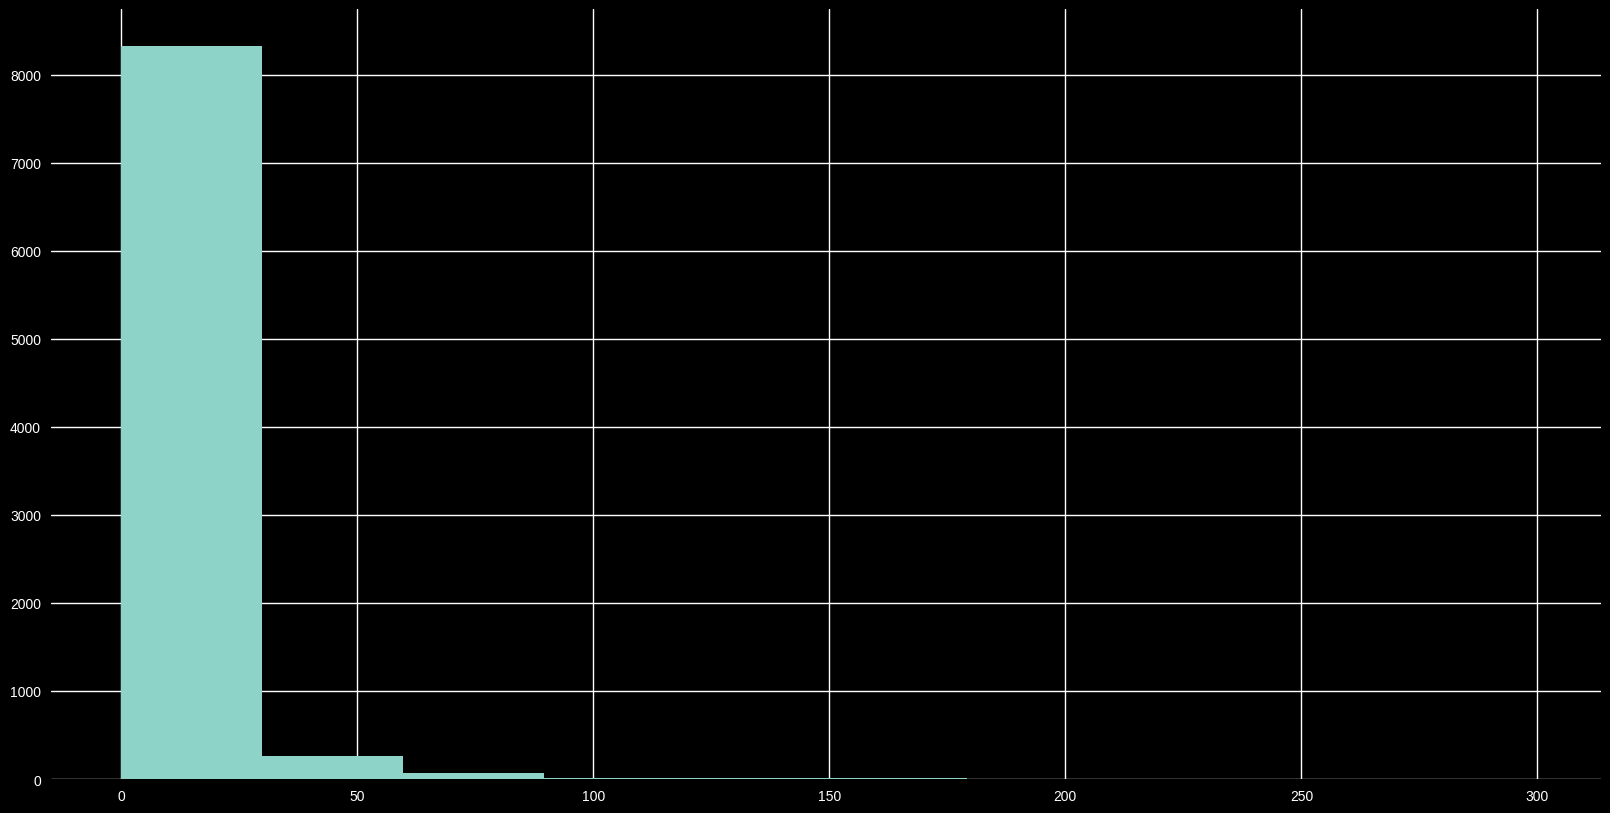

In [62]:
rob_scale = RobustScaler()
rob_scale.set_output(transform='pandas')
rob_temp = rob_scale.fit_transform(train_set[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
rob_temp.RoomService.hist()

In [63]:
# X_train,X_test,y_train,y_test = train_test_split(train_set)

In [64]:
total_train.num.unique()

array([   0.,    1.,    2., ..., 1892., 1893., 1894.], dtype=float32)

/tmp/ipykernel_12181/3961580489.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



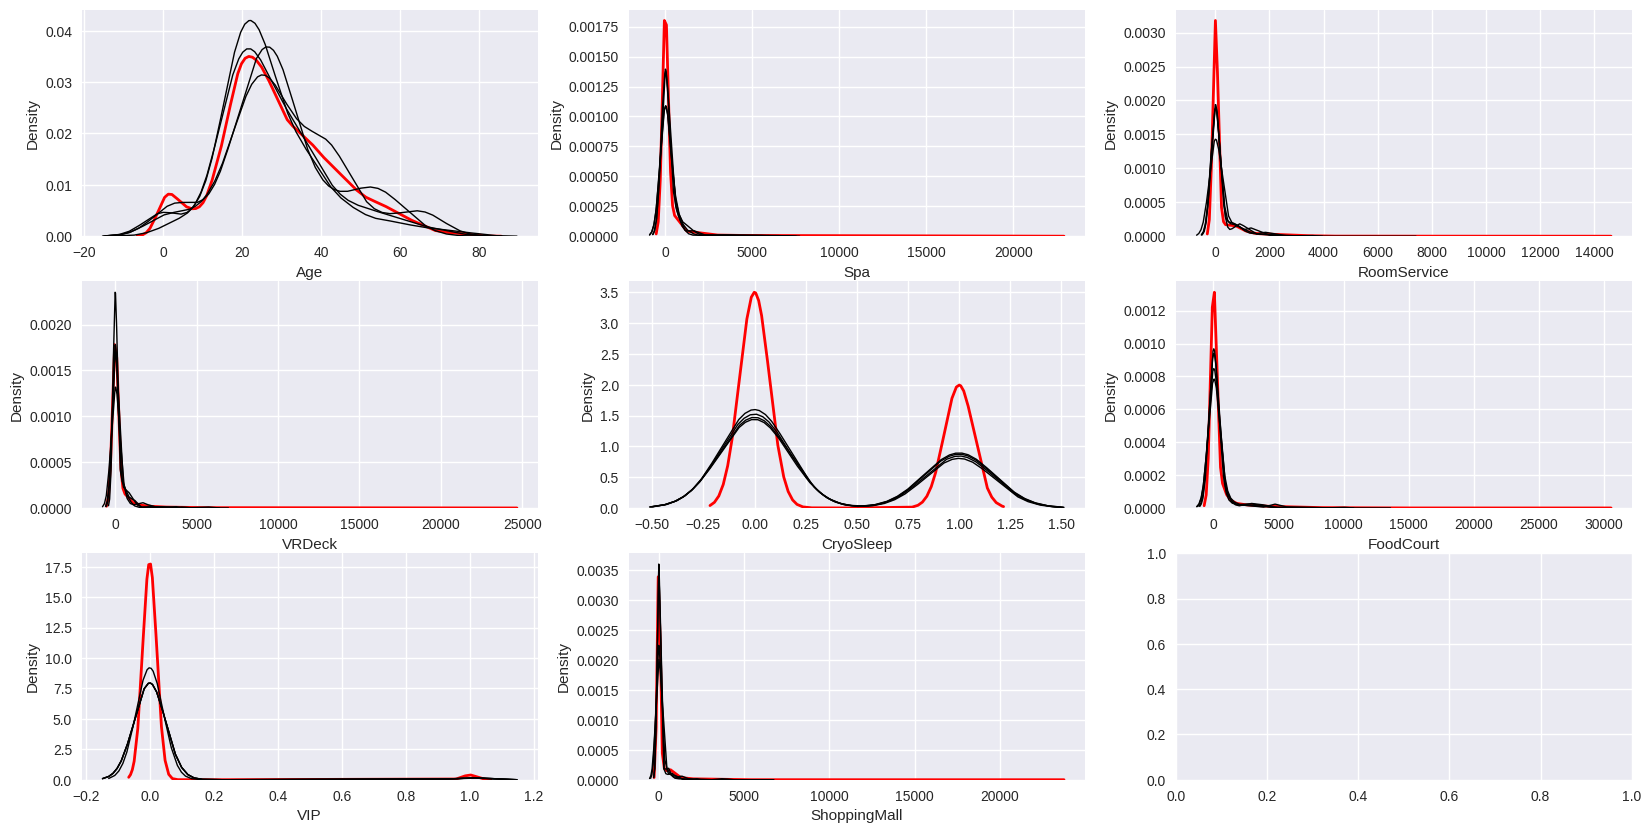

In [65]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (20,10)
kds.plot_imputed_distributions()

Axes(0.125,0.11;0.62x0.77)


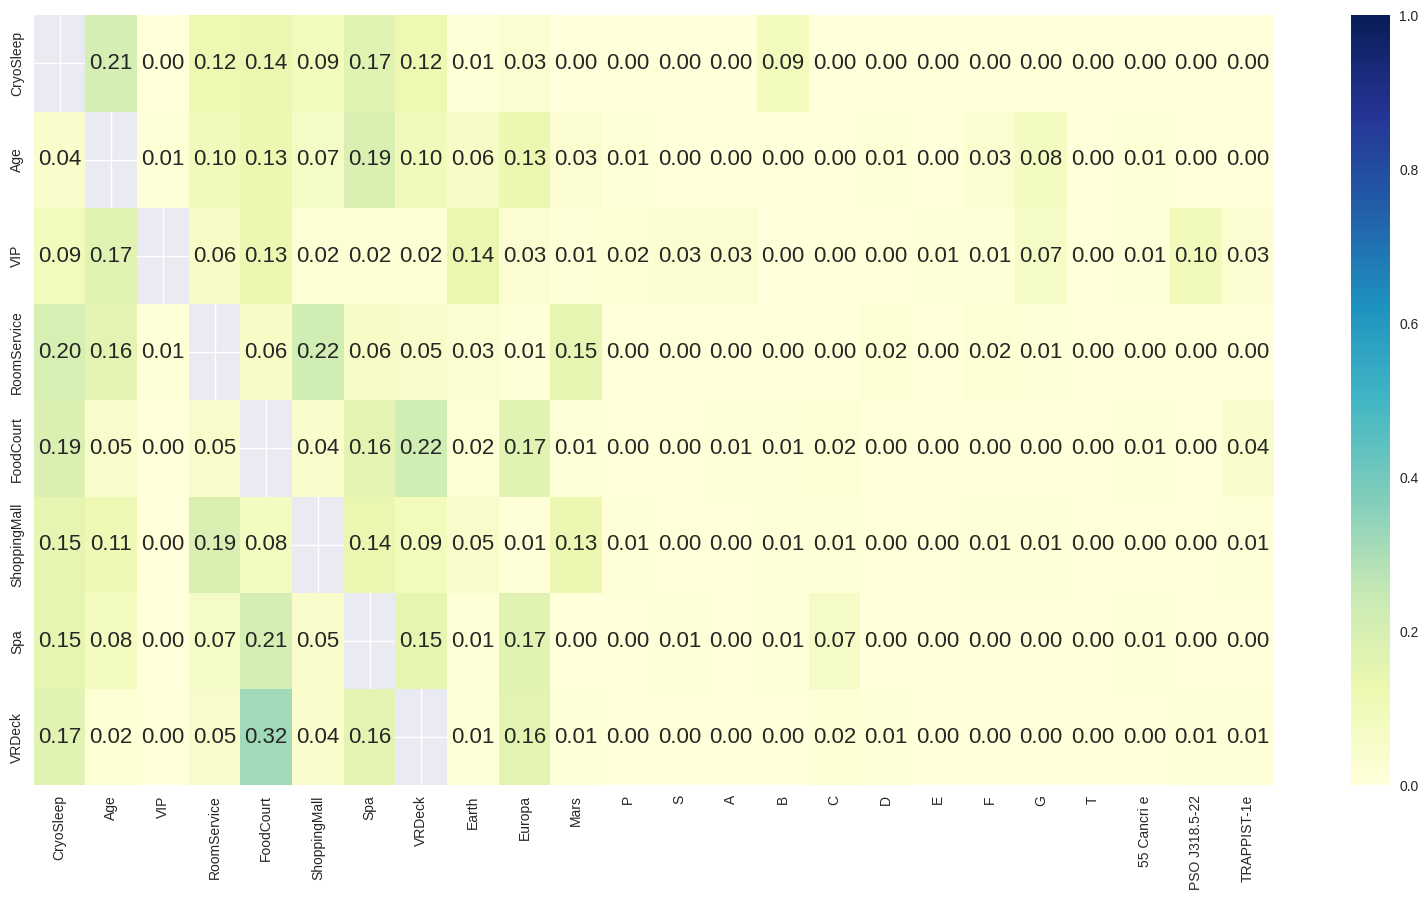

In [70]:
kds.plot_feature_importance(dataset=0,annot=True,cmap="YlGnBu",vmin=0,vmax=1)

In [75]:
kds.plot_correlations()

TypeError: 'NoneType' object is not iterable

In [66]:
class TotalTransform(BaseEstimator,TransformerMixin):

    def __init__(self,train=True):
        self.train = train

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        pass

# Rough Work

In [67]:
# check for corr() coefficient
# arr1 = np.random.randint(20,40,30)
# arr2 = np.random.randint(1,20,30)
# temp_df = pd.DataFrame(np.hstack([arr1,arr2]),columns=["num"])
# temp_df.loc[:30,'choice'] = 0
# temp_df.loc[30:,'choice'] = 1
# temp_df.corr()
# check for same deck,num,side in total_na
# num = 2
# total_no_na.query(f"Last == '{total_na.query('deck != deck').Last.iloc[num]}' and Group == {total_na.query('deck != deck').Group.iloc[num]}")